In [1]:
import wmfdata as wmf
import pandas as pd
import numpy as np
from wmfdata import spark,hive
from datetime import datetime

You are using Wmfdata v2.0.0, but v2.0.1 is available.

To update, run `pip install --upgrade git+https://github.com/wikimedia/wmfdata-python.git@release`.

To see the changes, refer to https://github.com/wikimedia/wmfdata-python/blob/release/CHANGELOG.md.


In [2]:
# Load data
wikis=pd.read_csv('data/wikis')
file = "https://analytics.wikimedia.org/published/datasets/knowledge_gaps/content_gaps/csv/gender.csv"
gendata = pd.read_csv(file)
# only wikipedia projects
gendata=gendata[gendata.wiki_db.isin(list(wikis['database_code']))]


In [3]:
# Since each snapshot contains patial data of the month it is published it in: we filter the data from previous month if the data was pulled too early. *Needs to be revisited

# Convert 'time_bucket' to datetime for comparison
#gendata['time_bucket'] = pd.to_datetime(gendata['time_bucket'])


# If today's day is before the 23rd of the month, filter out the previous month's data
#if datetime.now().day < 23:
#    prev_month = datetime.now().month - 1 if datetime.now().month > 1 else 12
#    gendata = gendata[gendata['time_bucket'].dt.month != prev_month]

In [16]:
# load original gen_data

old_gen = pd.read_csv('data/updated_gender.csv') 
old_gen['time'] = pd.to_datetime(old_gen['time'])


In [17]:
# Define a function to map categories to the new categories
def map_gender_category(category):
    if category in ['male', 'cisgender male']:
        return 'male'
    elif category in ['female', 'cisgender female']:
        return 'female'
    else:
        return 'gender_diverse'

# Create a new column gender3category
gendata['gender3category'] = gendata['category'].apply(map_gender_category)


In [18]:
#overtime quality articles
gen3quality=gendata.groupby(['gender3category','time_bucket'])['standard_quality_count_value'].sum().reset_index()

# Pivot the dataframe
gen3quality = gen3quality.pivot(index='time_bucket', columns='gender3category', values='standard_quality_count_value').reset_index()
gen3quality = gen3quality[gen3quality['time_bucket'] != '2023-09']


In [19]:
#aggregate
gen3quality['time'] = pd.to_datetime(gen3quality['time_bucket'])

# Identify the latest 'time' in old_geo_data
latest_time = old_gen['time'].max()

# Filter rows from total quality articles where 'time' is greater than latest_time from old_data to identify rows to be added
filtered_rows = gen3quality[gen3quality['time'] > latest_time]



# Filter columns of last_row based on columns in geo_data
old_gen = pd.concat([old_gen, filtered_rows], axis=0, ignore_index=True, sort=False)



In [20]:
# check if any new data was added to the spreadsheet


'''
The code below computes the monthly metric and the quarterly metric in the following way:

1) Monthly metric: Contained in the column called 'proportion_of_non_male'.  It is computed as the yoy-difference from 2022 and 2023 (difference calculated over 12 periods).  

2) Quarterly metric: Conatained in the column called 'quarterly_metric'.  It is computed as the average of yoy-difference of the monthly metrics of July 2023 and August 2023.  Since September data is not fully available, 
it is just the average of the first 2 months in the quarter (July and August).



'''



if filtered_rows.empty:
    print("No data has been added to the original spreadsheet. Will not overwrite updated_gender.csv")    
    rolling_avg_yoy = old_gen.copy()
    rolling_avg_yoy = rolling_avg_yoy.drop(columns=['time_bucket']) # use old_gen as output since no new rows were added.
    
else:
    # Compute the Year-over-Year difference
    rolling_avg_yoy = old_gen.copy()

    # Compute the 12-month YoY difference for "female" column
    rolling_avg_yoy['female_YoY_difference'] = rolling_avg_yoy['female'].diff(12)


    # Compute the 12-month YoY difference for men column
    rolling_avg_yoy['men_YoY_difference'] = rolling_avg_yoy['male'].diff(12)


    # Compute the 12-month YoY difference for gender diverse column
    rolling_avg_yoy['gender_diverse_YoY_difference'] = rolling_avg_yoy['gender_diverse'].diff(12)
    
    
# Get total
    columns_to_sum = ['female_YoY_difference', 'men_YoY_difference', 'gender_diverse_YoY_difference']
    rolling_avg_yoy['total'] = rolling_avg_yoy[columns_to_sum].sum(axis=1)
    


    # create proportion column to capture women + gender diverse
    rolling_avg_yoy['metric_gender_diverse+women'] = rolling_avg_yoy[['female_YoY_difference','gender_diverse_YoY_difference']].sum(axis=1)/rolling_avg_yoy['total'] * 100

    # Reorder columns to make 'time' the first column
    rolling_avg_yoy = rolling_avg_yoy[['time'] + [col for col in rolling_avg_yoy if col != 'time']]
   
    # Round the columns and drop extra columns
    columns_to_round = [col for col in rolling_avg_yoy.columns if col not in ['metric_gender_diverse+women', 'time']]
    rolling_avg_yoy[columns_to_round] = rolling_avg_yoy[columns_to_round].round(decimals=0)
    rolling_avg_yoy = rolling_avg_yoy.drop(columns=['time_bucket'])
    
    # Make metric column into %
    
    rolling_avg_yoy['proportion_of_non_male'] = rolling_avg_yoy['metric_gender_diverse+women'] 
    #rolling_avg_yoy['metric_gender_diverse+women'] = (rolling_avg_yoy['metric_gender_diverse+women'] * 100).round()
    #rolling_avg_yoy['metric_gender_diverse+women'] = rolling_avg_yoy['metric_gender_diverse+women'].replace([np.inf, -np.inf, np.nan], 0).astype(int).astype(str) + '%'

    
    copied_df = rolling_avg_yoy.copy()

    # 3. Filter the copied DataFrame for the rows of August and July 2023
    august_july_data = copied_df[copied_df['time'].isin([pd.Timestamp('2023-08-01'), pd.Timestamp('2023-07-01')])]

    # 4. Specify columns to average
    cols_to_average = ['female_YoY_difference', 'men_YoY_difference', 'gender_diverse_YoY_difference']
    average_values = august_july_data[cols_to_average].mean()

    # Replace values in the row corresponding to '2023-08-01' with average_values
    copied_df.loc[copied_df['time'] == '2023-08-01', cols_to_average] = average_values.values
    copied_df['total'] = copied_df[['female_YoY_difference', 'men_YoY_difference', 'gender_diverse_YoY_difference']].sum(axis=1)

    # 5. Calculate the quarterly metric as a proportion of gender_diverse_YoY_difference and female_YoY_difference
    copied_df['quarterly_metric'] = ((copied_df['gender_diverse_YoY_difference'] + copied_df['female_YoY_difference']) / copied_df['total']) * 100

    # 6. Append the created quarterly_metric column to rolling_avg_yoy
    rolling_avg_yoy['quarterly_metric'] = copied_df['quarterly_metric']
    
    
    #output
    
    rolling_avg_yoy.to_csv('data/updated_gender.csv', index=False)
    print("updated csv file")
 
    
    

updated csv file


In [21]:
   print("The latest monthly metrics are: ")
rolling_avg_yoy.drop(columns=['metric_gender_diverse+women']).tail(1) # View data

The latest monthly metrics are: 


,time,women YoY difference (3m),gender_diverse_YoY_difference (3m),men YoY difference (3m),female,male,gender_diverse,female_YoY_difference,men_YoY_difference,gender_diverse_YoY_difference,total,proportion_of_non_male,quarterly_metric
271,2023-08-01,NaN,NaN,NaN,355475,1252807,4052,39199.0,112381.0,605.0,152185.0,26.155009,26.40621


# Naive Forecast

In [22]:
'''
The forecast is calculated by getting the difference between the change in the average metric from Q2 2022 and Q3 2022 and then adding that change onto the calculated quarterly metric
for Q2 2023 (the average of July and August).


'''


# Define the months for Q2 and Q3
q2_dates = ['2022-07-01', '2022-08-01', '2022-09-01']
q3_dates = ['2022-10-01', '2022-11-01', '2022-12-01']

# Filter the data for Q2 and Q3 separately
q2_data = rolling_avg_yoy[rolling_avg_yoy['time'].isin(q2_dates)].copy()
q3_data = rolling_avg_yoy[rolling_avg_yoy['time'].isin(q3_dates)].copy()

# Calculate combined YoY difference for female and gender diverse for Q2 and Q3
q2_data['combined_YoY'] = q2_data['female_YoY_difference'] + q2_data['gender_diverse_YoY_difference']
q3_data['combined_YoY'] = q3_data['female_YoY_difference'] + q3_data['gender_diverse_YoY_difference']

# Compute the average of the combined values and the total for each quarter
avg_combined_q2 = q2_data['combined_YoY'].mean()
avg_combined_q3 = q3_data['combined_YoY'].mean()

avg_total_q2 = q2_data['total'].mean()
avg_total_q3 = q3_data['total'].mean()

# Calculate the proportion for each quarter
prop_q2 = avg_combined_q2 / avg_total_q2
prop_q3 = avg_combined_q3 / avg_total_q3

# Compute the delta between Q3 and Q2
delta = prop_q3 - prop_q2

# Get the last available value of quarterly_metric
last_quarterly_metric = rolling_avg_yoy[rolling_avg_yoy['time'] == '2023-08-01']['quarterly_metric'].values[0]

# Forecast for Q3 2023
forecast_q3 = last_quarterly_metric + delta

print(f"Delta between Q2 and Q3 2022: {delta*100:.2f} percentage points")
print(f"Last available quarterly metric (August 2023): {last_quarterly_metric:.2f}%")
print(f"Forecast for Q3 2023: {forecast_q3:.2f}%")



Delta between Q2 and Q3 2022: -0.01 percentage points
Last available quarterly metric (August 2023): 26.41%
Forecast for Q3 2023: 26.41%


# Generate monthly chart

Generating Women % Distribution chart...



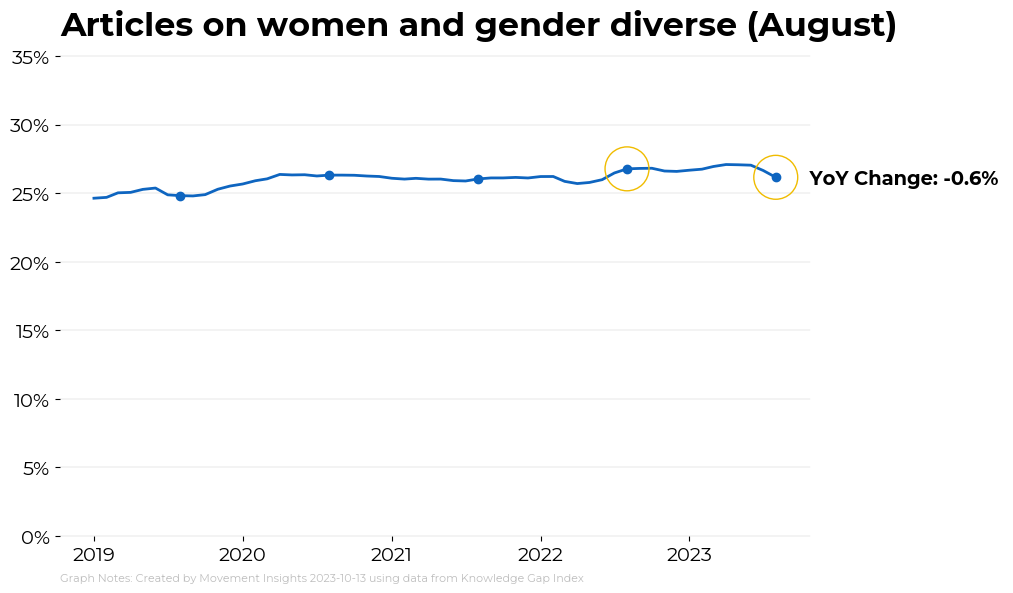

In [23]:
%run gender_gap_plot.ipynb